In [14]:
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout

from matplotlib import pyplot as plt

In [15]:
(X_train, y_train), (X_test, y_test) = load_data()

In [16]:
def load_real_samples():
	(X_train, _), (_, _) = load_data()
	# cConvert to float and scale.
	X = X_train.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5  #Generator uses tanh activation so rescale 
                            #original images to -1 to 1 to match the output of generator.
	return X

In [26]:
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	
	model.add(Conv2D(64, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))

	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))

	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid')) #shape of 1
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

test_discr = define_discriminator()
print(test_discr.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 16, 16, 64)        1792      
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_14 (Conv2D)          (None, 4, 4, 256)         295168    
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 4, 4, 256)         0         
                                                                 
 conv2d_15 (Conv2D)          (None, 2, 2, 256)       

In [18]:
def define_generator(latent_dim):    #latent_dim is the dimension of the latent vector (e.g., 100)
	model = Sequential()

	n_nodes = 256 * 4 * 4  #8192 nodes
	model.add(Dense(n_nodes, input_dim=latent_dim)) #Dense layer so we can work with 1D latent vector
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))  #8x8x128 dataset from the latent vector. 
	# upsample to 8x8
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #16x16x128
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #16x16x128
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #32x32x128
	model.add(LeakyReLU(alpha=0.2))
	# generate
	model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) #32x32x3
	return model  #Model not compiled as it is not directly trained like the discriminator.
                    #Generator is trained via GAN combined model. 

test_gen = define_generator(100)
print(test_gen.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 8192)              827392    
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 8192)              0         
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 16, 16, 128)       262272    
 Transpose)                                                      
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 32, 32, 128)       262272    
 Transpose)                                           

In [19]:
def define_gan(generator, discriminator):
	discriminator.trainable = False  #Discriminator is trained separately. So set to not trainable.
	# connect generator and discriminator
	model = Sequential()
	model.add(generator)
	model.add(discriminator)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [20]:
def generate_real_samples(dataset, n_samples):
	# choose random images
	ix = randint(0, dataset.shape[0], n_samples)
	# select the random images and assign it to X
	X = dataset[ix]
	# generate class labels and assign to y
	y = ones((n_samples, 1)) ##Label=1 indicating they are real
	return X, y

In [21]:
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [22]:
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict using generator to generate fake samples. 
	X = generator.predict(x_input)
	# Class labels will be 0 as these samples are fake. 
	y = zeros((n_samples, 1))  #Label=0 indicating they are fake
	return X, y

In [ ]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i])
	# save plot to file
	filename = 'CIFAR_imgs/generated_plot_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	plt.close()

In [23]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)  #the discriminator model is updated for a half batch of real samples and a half batch of fake samples, combined a single batch. 
	# manually enumerate epochs and bacthes. 
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
            
            # Train the discriminator on real and fake images, separately (half batch each)
        #Research showed that separate training is more effective. 
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
            ##train_on_batch allows you to update weights based on a collection 
            #of samples you provide
            #Let us just capture loss and ignore accuracy value (2nd output below)
			d_loss_real, _ = d_model.train_on_batch(X_real, y_real) 
			
            # generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)
            
            #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #Average loss if you want to report single..
            
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
             
            # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        #This is where the generator is trying to trick discriminator into believing
        #the generated image is true (hence value of 1 for y)			
			y_gan = ones((n_batch, 1))
            
            # Generator is part of combined model where it got directly linked with the discriminator
        # Train the generator with latent_dim as x and 1 as y. 
        # Again, 1 as the output as it is adversarial and if generator did a great
        #job of folling the discriminator then the output would be 1 (true)
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			
            # Print losses on this batch
			print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
	# save the generator model
	g_model.save('cifar_generator.h5')

In [24]:
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=2)

################################################################################

2/2 [==============================] - 0s 34ms/step
Epoch>1, Batch 1/390, d1=0.666, d2=0.710 g=0.683
2/2 [==============================] - 0s 31ms/step
Epoch>1, Batch 2/390, d1=0.403, d2=0.868 g=0.618
2/2 [==============================] - 0s 30ms/step
Epoch>1, Batch 3/390, d1=0.221, d2=1.190 g=0.695
2/2 [==============================] - 0s 31ms/step
Epoch>1, Batch 4/390, d1=0.183, d2=0.740 g=1.261
2/2 [==============================] - 0s 29ms/step
Epoch>1, Batch 5/390, d1=0.326, d2=0.516 g=1.128
2/2 [==============================] - 0s 29ms/step
Epoch>1, Batch 6/390, d1=0.202, d2=0.657 g=0.798
2/2 [==============================] - 0s 31ms/step
Epoch>1, Batch 7/390, d1=0.337, d2=0.952 g=0.644
2/2 [==============================] - 0s 30ms/step
Epoch>1, Batch 8/390, d1=0.280, d2=3.242 g=0.309
2/2 [==============================] - 0s 31ms/step
Epoch>1, Batch 9/390, d1=0.157, d2=2.552 g=1.530
2/2 [==============================] - 0s 30ms/step
Epoch>1, Batch 10/390, d1=0.433, d2=0.2

c:\Users\Raphael\anaconda3\envs\RL\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 103ms/step


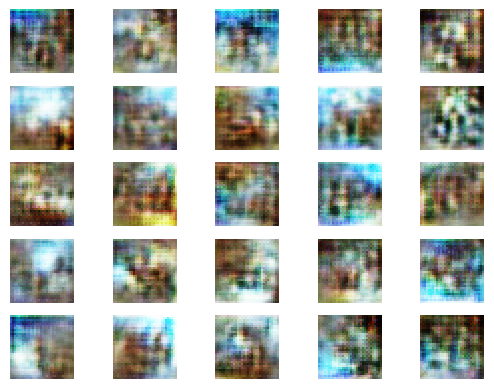

In [25]:
from tensorflow.keras.models import load_model
from numpy.random import randn


# Plot generated images 
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()

# load model
model = load_model('cifar_generator.h5') #Model trained for 100 epochs
# generate images
latent_points = generate_latent_points(100, 25)  #Latent dim and n_samples
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

import numpy as np
X = (X*255).astype(np.uint8)

# plot the result
show_plot(X, 5)